## Introduzione
La seguente analisi sulle serie temporali è stata effettuata prendendo in considerazione un dataset con informazioni orarie sull'inquinamento dell'aria a Pechino nel periodo che va daa 1 Gennaio 2010 al 31 Dicembre 2014.
L'obiettivo è quello di utilizzare metodi di analisi delle serie temporali quali ARIMA e SARIMAX per effettuare delle predizioni sul futuro stato di inquinamento dell'aria. Per effettuare le analisi sono stati utilizzati pandas, matplotlib, statsmodels e sklearn.

### Import del dataset
Iniziamo l'analisi importando il dataset in formato .csv ottenuto al link https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data
Successivamente visualizziamo i dati generali sulla struttura del dataset.

In [1]:
import pandas as pd
file_path = "AirData.csv"
air_data = pd.read_csv(file_path)

# Mostra le informazioni generali del dataset
air_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


## Descrizione dei dati:
Le colonne del dataset hanno il seguente significato:
- **No**: indice della riga o identificatore della misurazione.
- **year**: anno della misurazione
- **month**: mese della misurazione
- **day**: giorno della misurazione
- **hour**: ora della misurazione
- **pm2.5**: concentrazione delle polveri sottili nell'aria misurata in ug/m^3
- **DEWP**: punto di rugiada utilizzato come indice di umidità dell'aria
- **PRES**: pressione atmosferica
- **cbwd**: direzione del vento
- **lws**: velocità del vento
- **Is**: ore cumulative di neve 
- **Ir**: ore cumulative di pioggia

Il dataset fornisce tutte informazioni interessanti al fine di studiare la qualità dell'aria, per cui verranno mantenute tutte le colonne fatta eccezione per la direzione del vento, che risulta complessa da correlare all'inquinamento con i metodi sopra citati.
Prima di proseguire con l'analisi è necessario riformattare le informazioni sull'istante di misurazione utilizzando il formato datetime di pandas, che consente di aggregare in un solo dato le 4 colonne relative ad anno mese giorno e ora dell'acquisizione.
Dovrà inoltre essere eseguito un resample del dataset, saranno infatti aggregate le misure su base settimanale per avere dei dati più omogenei e allo stesso tempo aggirare il problema dei valori nulli per alcune istanze del campo pm2.5.

In [2]:
selected_columns = ['year','month','day','hour', 'pm2.5', 'DEWP', 'PRES','Iws','cbwd', 'Is','Ir']
air_data = air_data[selected_columns].copy()

# Conversione informazioni temporali in formato datetime
air_data['datetime'] = pd.to_datetime(air_data[['year', 'month', 'day', 'hour']])
selected_columns = ['datetime', 'pm2.5', 'DEWP', 'PRES','Iws', 'Is','Ir']
air_data = air_data[selected_columns].copy()
air_data.set_index('datetime', inplace=True)
air_data['Is'] = (air_data['Is'] > 0).astype(int)
air_data['Ir'] = (air_data['Ir'] > 0).astype(int)

air_data.sort_index(inplace=True)
air_data = air_data.resample('W').agg({
    'pm2.5': 'mean',
    'DEWP': 'mean', 
    'PRES': 'mean',
    'Iws':'mean',
    'Is': 'sum',
    'Ir': 'sum'
})

# Mostra statistiche descrittive del dataset
print(air_data.head())
print(air_data.describe())




                 pm2.5       DEWP         PRES        Iws  Is  Ir
datetime                                                         
2010-01-03  112.395833 -12.458333  1021.541667  36.752083  30   0
2010-01-10   74.452381 -19.976190  1031.470238  32.778571   0   0
2010-01-17   86.708333 -18.083333  1031.345238  43.464464   0   0
2010-01-24  132.992701 -14.202381  1028.255952  38.843810   0   0
2010-01-31   63.401515 -17.744048  1023.738095  51.740417   0   0
            pm2.5        DEWP         PRES         Iws          Is          Ir
count  262.000000  262.000000   262.000000  262.000000  262.000000  262.000000
mean    98.648145    1.747221  1016.470147   23.999760    1.404580    6.900763
std     44.669512   13.607754     9.289064   23.316269    5.019928    9.413331
min     25.668874  -21.184524   997.267857    3.302202    0.000000    0.000000
25%     69.336723  -10.361607  1008.111607   10.094107    0.000000    0.000000
50%     86.946429    2.449405  1016.970238   15.260208    0.0000

Come si può notare dalle statistiche non sembrano esserci valori sospetti e quindi errori di acquisizione dei dati, inoltre dal count delle istanze si capisce che non ci sono valori mancanti.

## Analisi esplorativa del dataset

Effetuiamo un'analisi visiva del dataset graficando l'andamento della concentrazione di polveri sottili, in questo modo possiamo avanzare una prima ipotesi sulla stazionarietà della serie.

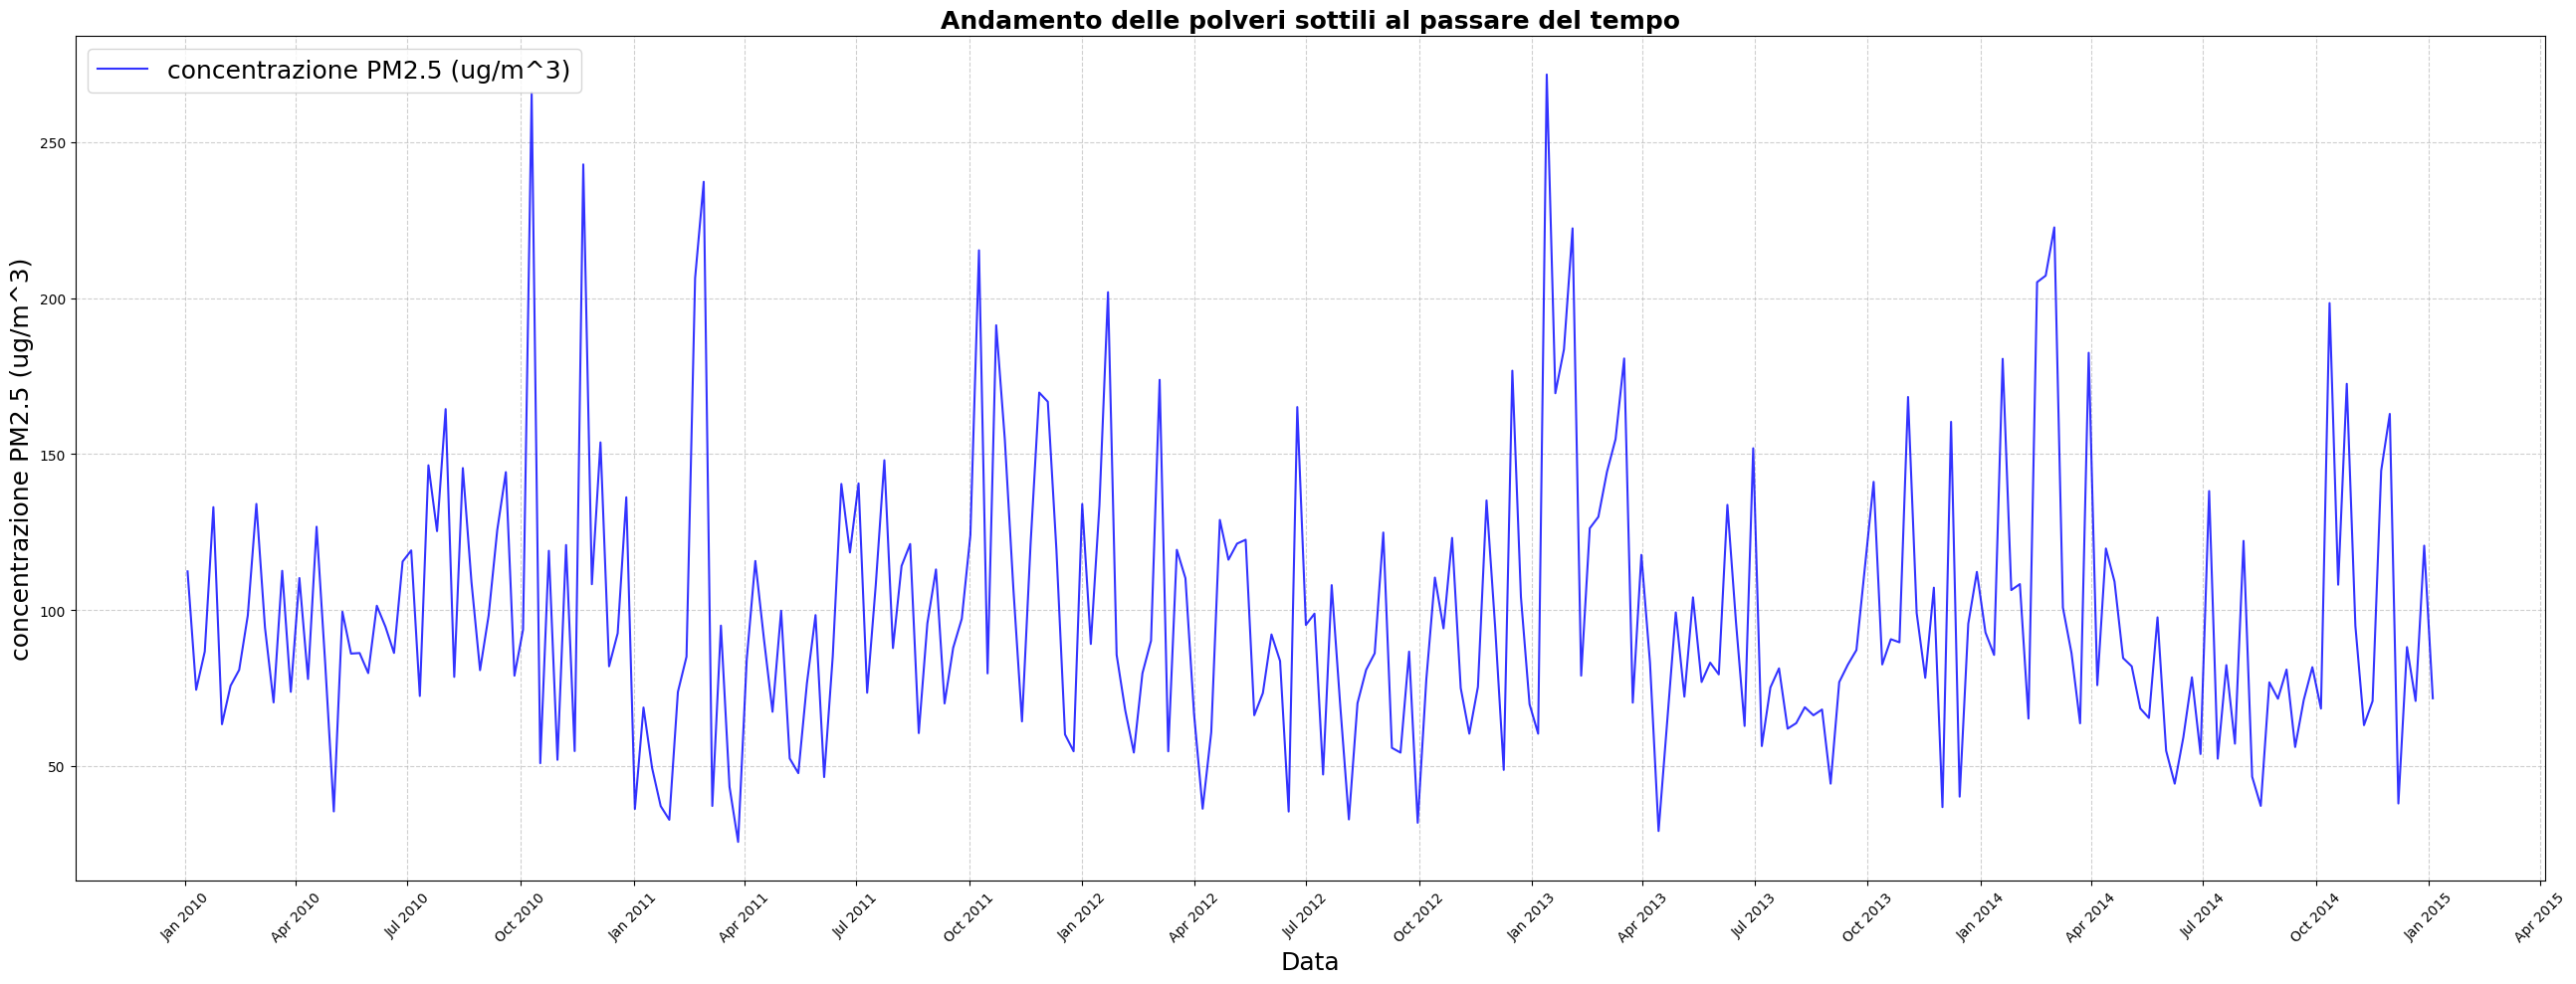

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(26, 10))
plt.plot(air_data['pm2.5'], label='concentrazione PM2.5 (ug/m^3)', alpha=0.8, linewidth=1.5, color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formattazione mese/anno
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Intervallo di 3 mesi
plt.xticks(rotation=45)
plt.title('Andamento delle polveri sottili al passare del tempo', fontsize=18, fontweight='bold')
plt.xlabel('Data', fontsize=18)
plt.ylabel('concentrazione PM2.5 (ug/m^3)', fontsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

A prima vista la serie sembra rispettare la definizione di stazionarietà debole, secondo la quale la media e la varianza della serie non devono variare nel tempo. Si può notare anche una certa stagionalità con valori di picco a Gennaio e Ottobre e valori più contenuti tra Aprile e Luglio. Per effettuare un'analisi più approfondita decomponiamo la serie nelle sue componenti stagionali, di trend e residuali.

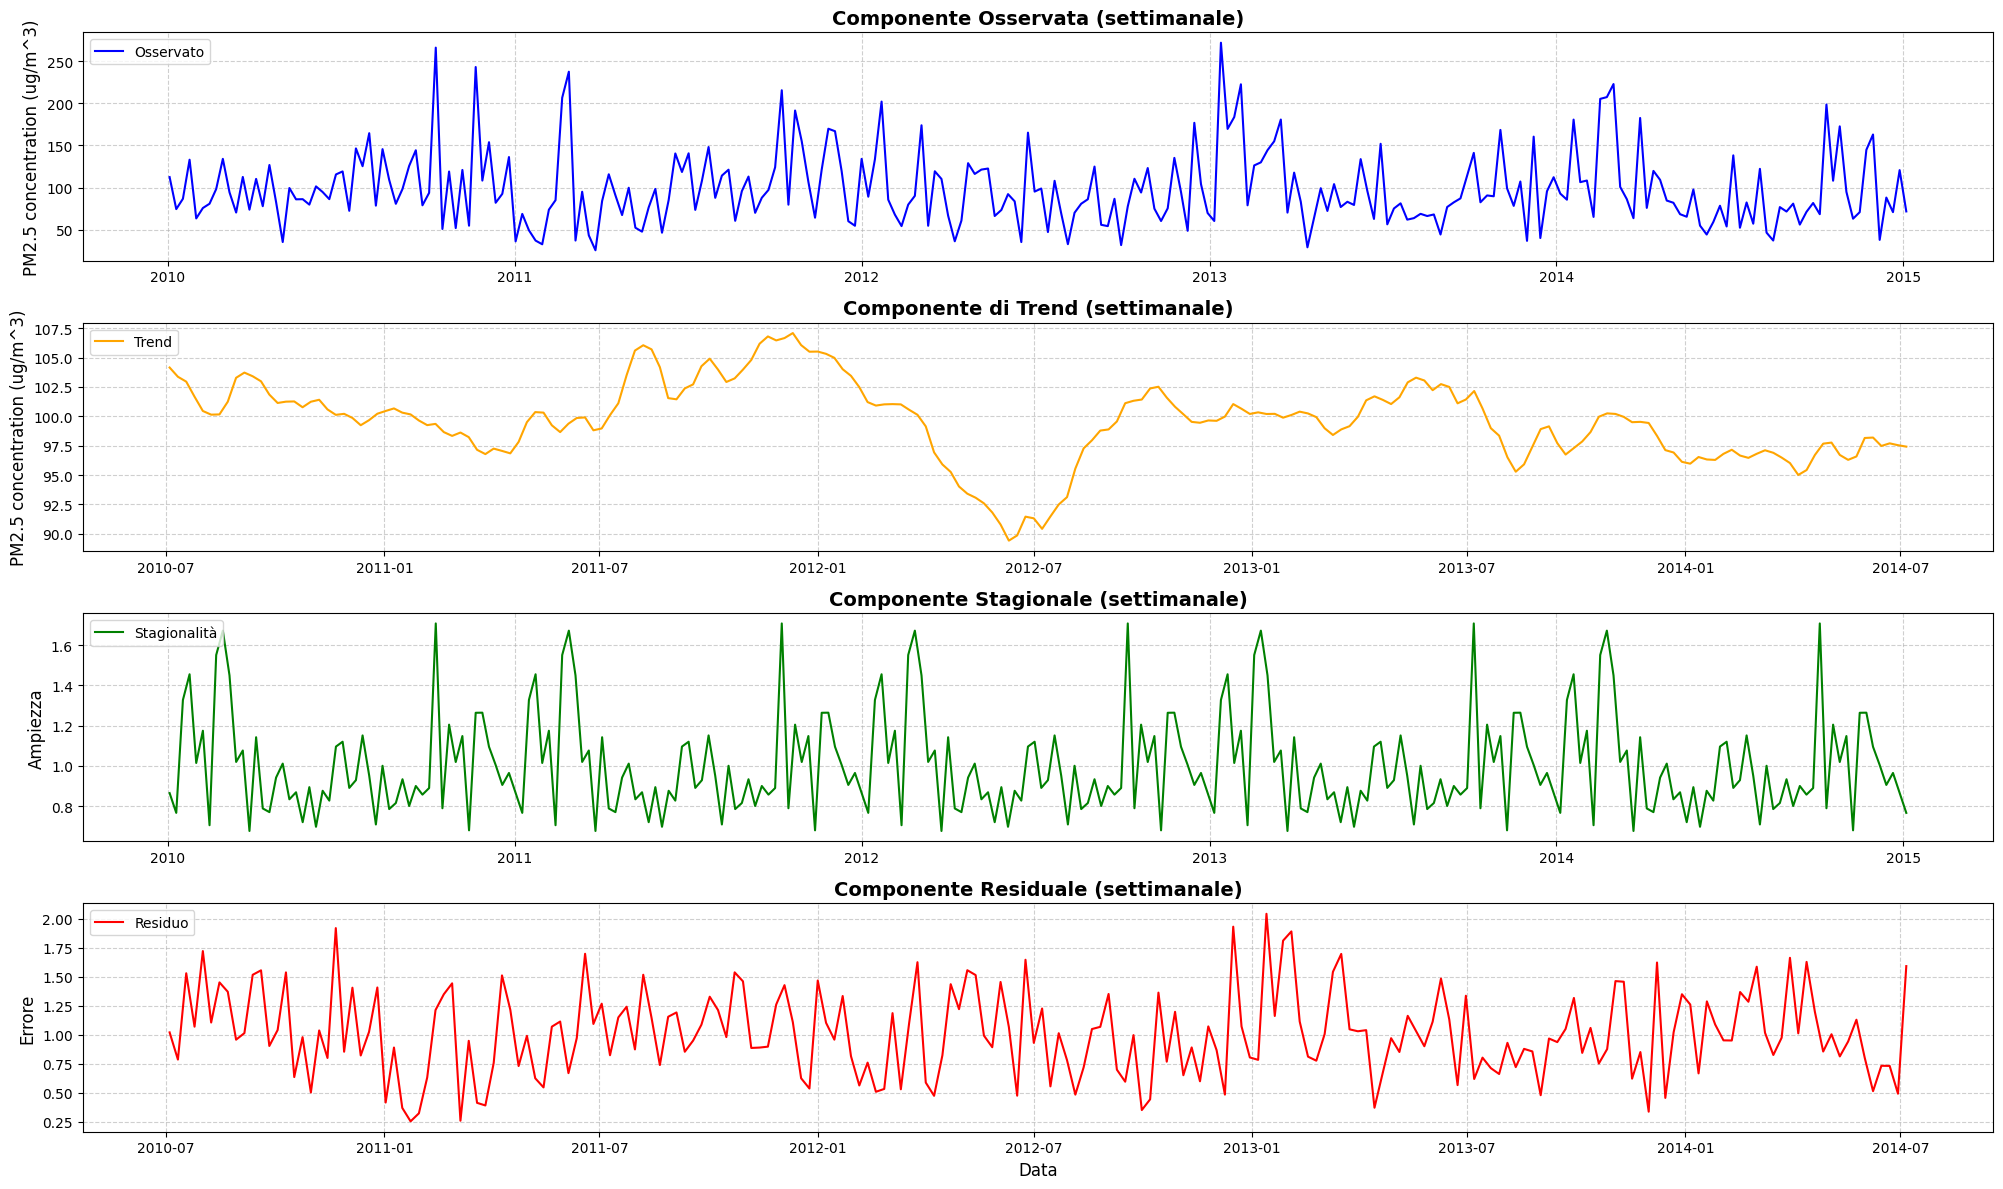

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposizione della serie temporale settimanale
decomposition = seasonal_decompose(air_data['pm2.5'], model='multiplicative', period=52)  # 52 settimane per la stagionalità annuale
plt.figure(figsize=(20, 12))

# Osservato
plt.subplot(411)
plt.plot(decomposition.observed, label='Osservato', color='blue', linewidth=1.5)
plt.title('Componente Osservata (settimanale)', fontsize=14, fontweight='bold')
plt.ylabel('PM2.5 concentration (ug/m^3)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Trend
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange', linewidth=1.5)
plt.title('Componente di Trend (settimanale)', fontsize=14, fontweight='bold')
plt.ylabel('PM2.5 concentration (ug/m^3)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Stagionalità
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Stagionalità', color='green', linewidth=1.5)
plt.title('Componente Stagionale (settimanale)', fontsize=14, fontweight='bold')
plt.ylabel('Ampiezza', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Residuo
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuo', color='red', linewidth=1.5)
plt.title('Componente Residuale (settimanale)', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Errore', fontsize=12)
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

La serie sembra non avere un trend ben definito, ha un pattern stagionale molto evidente, e una componente residuale che non rientra nel trend o nella stagionalità che risulta molto piccola, dunque per ora si può confermare l'ipotesi di stazionarietà debole. Per confermare l'ipotesi effettuiamo l'ADF Test (Augmented Dickey-Fuller) e misuriamo il p-value, che per serie stazionarie dovrebbe essere inferiore alla soglia di 0.05.

In [5]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(air_data['pm2.5'].dropna())

adf_results = pd.Series({"ADF Test Statistic": adf_test[0],
            "p-value": adf_test[1],
            "Lags Used": adf_test[2],
            "Number of Observations": adf_test[3],
            "Critical Value (1%)": adf_test[4]["1%"],
            "Critical Value (5%)": adf_test[4]["5%"],
            "Critical Value (10%)": adf_test[4]["10%"]})
adf_results

ADF Test Statistic       -9.268388e+00
p-value                   1.347449e-15
Lags Used                 1.000000e+00
Number of Observations    2.600000e+02
Critical Value (1%)      -3.455754e+00
Critical Value (5%)      -2.872721e+00
Critical Value (10%)     -2.572728e+00
dtype: float64

Il p-value è sotto la soglia 0.05, inoltre la statistica di test è inferiore a tutti i valori critici; dunque si può confermare che la serie sia stazionaria. Procediamo dunque con l'analisi dei correlogrammi ACF e PACF per stimare i parametri (p, d, q) del modello SARIMA.

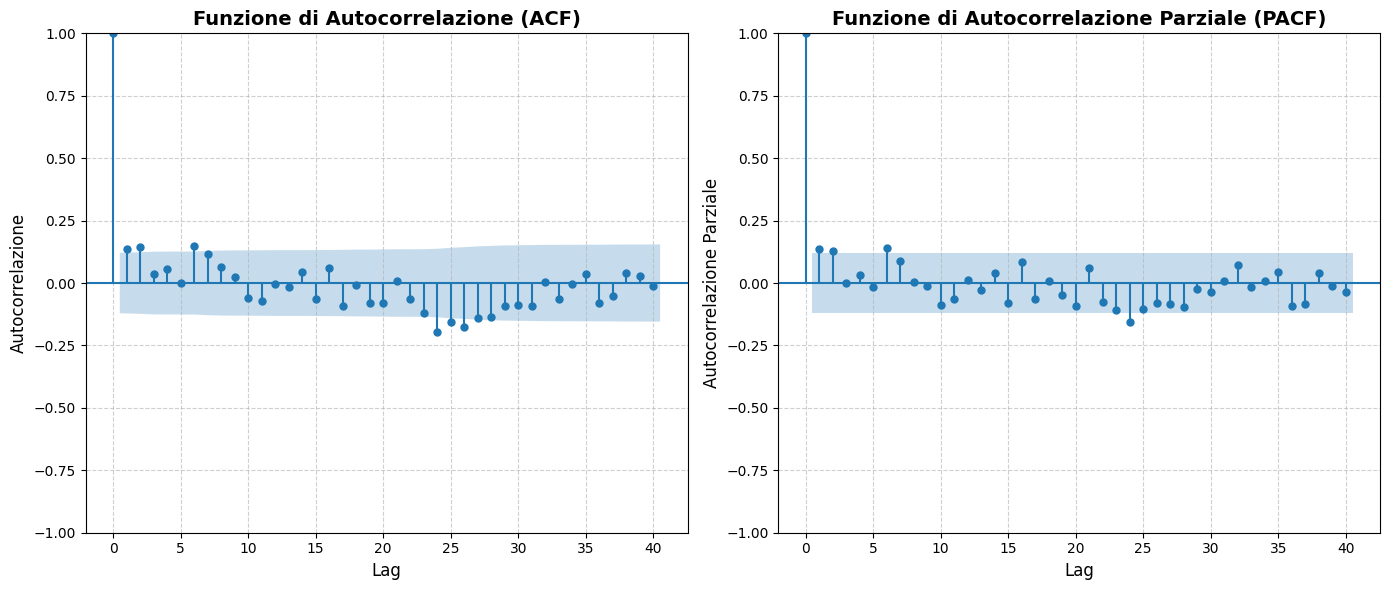

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Creazione dei grafici ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# ACF
plot_acf(air_data['pm2.5'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Funzione di Autocorrelazione (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelazione', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# PACF
plot_pacf(air_data['pm2.5'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Funzione di Autocorrelazione Parziale (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Autocorrelazione Parziale', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Mostra i grafici
plt.tight_layout()
plt.show()

## Analisi dei correlogrammi


- ACF (Funzione di Autocorrelazione):
Il grafico ACF mostra la correlazione tra la serie temporale e i suoi valori passati (lag). Nel caso in esame solo il primo lag supera in modo evidente la soglia di 
significatività, i valori successivi si mantengono intorno allo zero, cosa che lascia intuire un modello con un termine di media mobile di ordine 1 (q=1).
- PACF (Funzione di Autocorrelazione Parziale):
Il grafico PACF evidenzia una correlazione diretta significativa al primo lag, mentre gli altri lags mostrano correlazioni trascurabili.
Suggerisce che la componente autoregressiva (AR) ha una struttura di basso ordine, probabilmente con p = 1.
- Risultati:
L’ACF e il PACF insieme suggeriscono che la serie può essere ben rappresentata con un modello (1, 0, 1).

## Costruzione Modello ARIMA
Proseguiamo l'analisi utilizzando la libreria pmdarima e in particolare la funzione auto_arima per verificare che i valori p, d, q trovati coincidano con quelli suggeriti dalla libreria.

In [7]:
from pmdarima import auto_arima

# Utilizzo di auto_arima per trovare i parametri migliori
auto_arima_model = auto_arima(
    air_data['pm2.5'],
    seasonal=True,  # Nessuna stagionalità per ora
    trace=True,      # Mostrare il processo
    error_action='ignore',  # Ignora errori
    suppress_warnings=True, # Sopprimi i warning
    stepwise=True,          # Approccio iterativo per trovare i migliori parametri
    max_order=10            # Limite sulla somma di p+d+q
)
# Mostrare i parametri migliori trovati
print(auto_arima_model.summary())

C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2734.547, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2737.350, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2734.480, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2735.505, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3200.198, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2732.243, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2734.243, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2734.243, Time=0.05 sec


C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2732.171, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2734.402, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2732.807, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2747.188, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.766 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  262
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1362.085
Date:                Tue, 13 May 2025   AIC                           2732.171
Time:                        15:20:59   BIC                           2746.444
Sample:                    01-03-2010   HQIC                          2737.907
                         - 01-04-2015                                         
Covariance Type:                  opg                                         
                 coef    st

C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\loris\PycharmProjects\serie temporali\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Come si può notare il modello che minimizza l'AIC è effettivamente quello con parametri 1, 0, 1. Dunque si può procedere con l'analisi dei residui prodotti da tale modello, per assicurarci che non ci siano pattern particolari (cioè cerchiamo media e varianza costante).

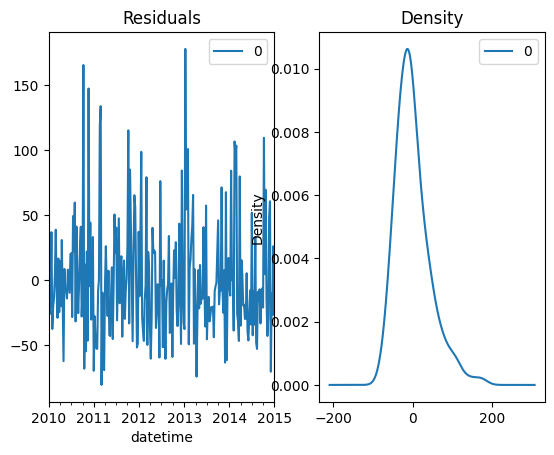

In [8]:
residuals= pd.DataFrame(auto_arima_model.resid())
fig, ax = plt.subplots(1, 2)
residuals.plot(title = "Residuals", ax=ax[0])
residuals.plot(kind = 'kde',title = "Density", ax=ax[1])
plt.show()

Gli errori residuali sembrano essere contenuti con una media prossima allo zero e una varianza uniforme. Dunque il modello è coerente.

## Addestramento del modello
Andiamo infine ad addestrare e testare il modello dividento il dataset in 80% training e 20% test, così da poter simulare un addestramento su 4 anni di misurazioni e valutare i risultati su un intero anno (il quinto).

MAE: 36.21
RMSE: 48.00


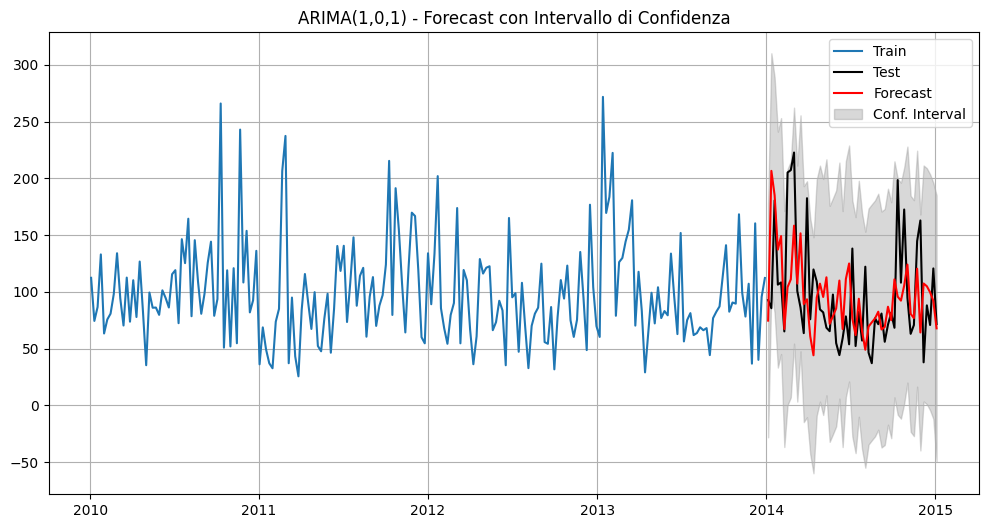

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

split_index = int(len(air_data) * 0.8)

train_data, test_data = air_data.iloc[:split_index]['pm2.5'], air_data.iloc[split_index:]['pm2.5']
# Concatenare dati di training e test per avere l'intera serie storica
full_data = air_data['pm2.5']

model = SARIMAX(train_data, order=(1, 0, 1), seasonal_order=(1, 1, 0, 52), trend="n") # "n" = no trend
model_fit = model.fit(disp=False)

forecast_object = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()


mse = mean_squared_error(test_data, forecast_mean)
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label="Train")
plt.plot(test_data.index, test_data, label="Test", color="black")
plt.plot(test_data.index, forecast_mean, label="Forecast", color="red")

# Aggiungi intervallo di confidenza
plt.fill_between(test_data.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='grey', alpha=0.3, label='Conf. Interval')

plt.legend()
plt.title("ARIMA(1,0,1) - Forecast con Intervallo di Confidenza")
plt.grid(True)
plt.show()

Le prestazioni del modello mostrano metriche non particolarmente brillanti, cosa abbastanza comune per le analisi meteorologiche. Ciò che risulta promettente, però, è che il modello abbia tracciato in modo abbastanza coerente con i dati effettivi l'andamento della serie. Come passo successivo costruiremo un modello SARIMAX arricchendo la serie temporale con gli altri dati del dataset.

## Modello SARIMAX
Per migliorare le prestazioni del modello possiamo utilizzare come variabili esogene le altre informazioni del dataset, con l'obiettivo di rendere più accurate le predizioni. Come evidenziato precedentemente verranno utilizzate tutte le informazioni fatta eccezione per la direzione del vento.


MAE: 26.90
RMSE: 34.85


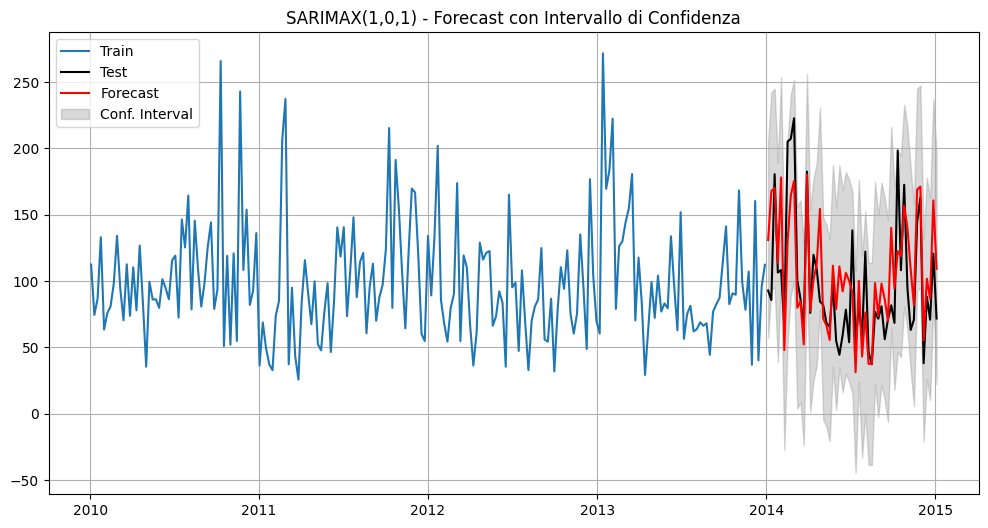

In [10]:


# Divisione delle variabili esogene
train_exog = air_data.iloc[:split_index][['DEWP', 'PRES','Iws', 'Is','Ir']]
test_exog = air_data.iloc[split_index:][['DEWP', 'PRES','Iws', 'Is','Ir']]

sarimax_model = SARIMAX(train_data, order=(1, 0, 1),  exog=train_exog, seasonal_order=(1, 1, 0, 52), trend="n") # "n" = no trend
sarimax_model_fit = sarimax_model.fit(disp=False)

forecast_object = sarimax_model_fit.get_forecast(steps=len(test_data), exog=test_exog)
forecast_mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()


mse = mean_squared_error(test_data, forecast_mean)
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label="Train")
plt.plot(test_data.index, test_data, label="Test", color="black")
plt.plot(test_data.index, forecast_mean, label="Forecast", color="red")

# Aggiungi intervallo di confidenza
plt.fill_between(test_data.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='grey', alpha=0.3, label='Conf. Interval')

plt.legend()
plt.title("SARIMAX(1,0,1) - Forecast con Intervallo di Confidenza")
plt.grid(True)
plt.show()

Come si può vedere dalle metriche e dal grafico, l'utilizzo delle variabili esogene ha consetito di aumentare la precisione delle predizioni, e dunque migliorare le prestazioni del modello. Concludiamo l'analisi andando ad esaminare i residui del modello SARIMAX.

## Analisi dei residui SARIMAX

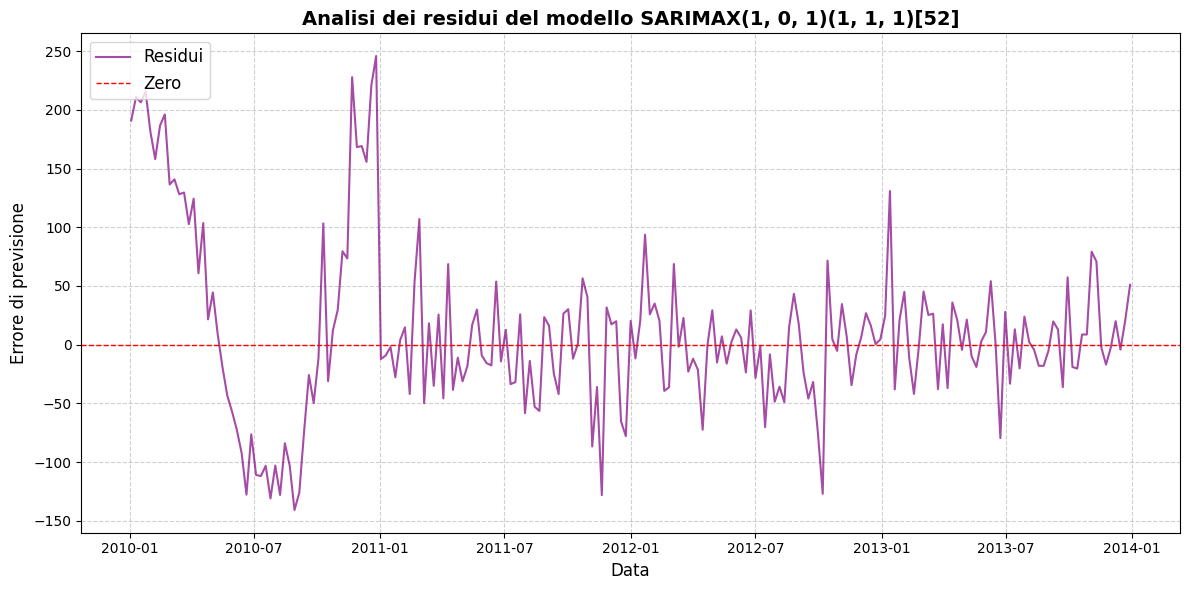

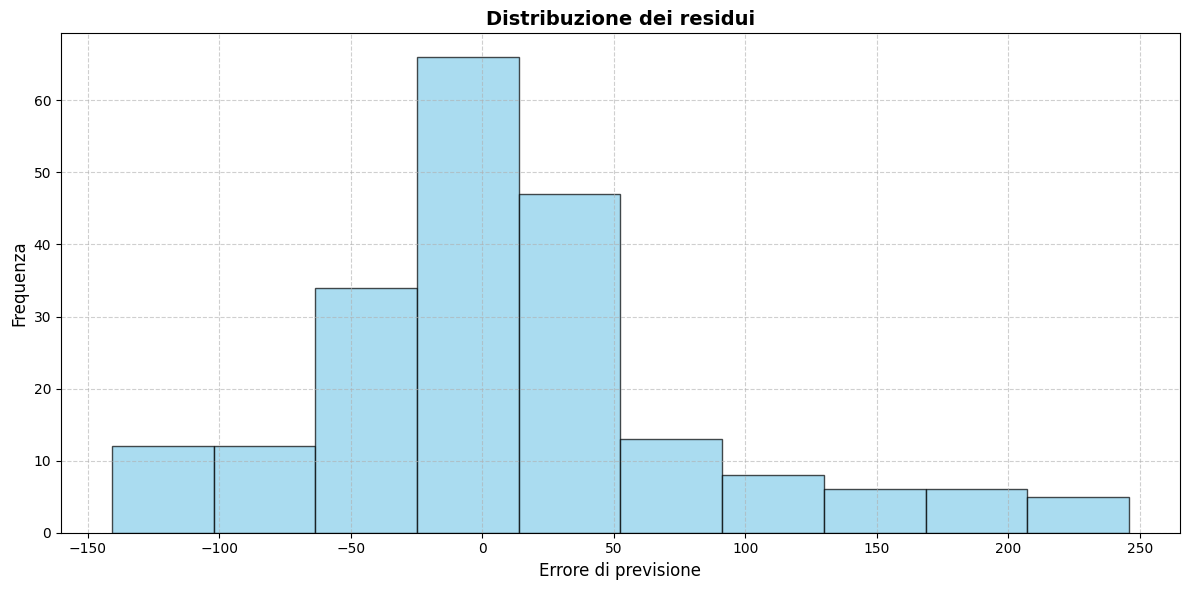

In [11]:
# Analisi dei residui del modello SARIMAX
residuals_sarimax = sarimax_model_fit.resid

# Grafico dei residui
plt.figure(figsize=(12, 6))
plt.plot(residuals_sarimax, label='Residui', color='purple', alpha=0.7, linewidth=1.5)
plt.axhline(0, linestyle='--', color='red', linewidth=1, label='Zero')
plt.title('Analisi dei residui del modello SARIMAX(1, 0, 1)(1, 1, 1)[52]', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Errore di previsione', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Istogramma dei residui
plt.figure(figsize=(12, 6))
plt.hist(residuals_sarimax, bins=10, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribuzione dei residui', fontsize=14, fontweight='bold')
plt.xlabel('Errore di previsione', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Grafico della serie temporale dei residui:
I residui oscillano intorno a zero, un buon segno che indica che il modello non presenta bias sistematico. Tuttavia, sono presenti valori particolarmente elevati e con andamento stranamente lineare a tratti nel primo anno di misurazioni.
- Istogramma dei residui
L’istogramma dei residui mostra una distribuzione intorno allo zero con la presenza di alcuni valori reali molto alti che sono stati predetti come molto più piccoli, indizio del fatto che alcuni picchi nel valore di inquinamento non riescono ad essere rilevati preventivamente dal modello.

## Conclusioni
Confrontando i due modelli è evidente che l'utilizzo delle variabili esogene in SARIMAX ha consentito di aumentare l'accuratezza delle previsioni, tuttavia questo ha anche inciso negativamente sulle componenti residuali, le quali in alcuni casi hanno portato a residui di valore prossimo al massimo valore registrato per la concentrazione di polveri sottili. In altre parole, per questo caso di studio, ARIMA ha portato a previsioni appiattite e meno precise ma consistenti nel tempo, mentre SARIMAX ha consentito di essere mediamente più preciso, ma con delle eccezioni in cui la previsione si è rivelata totalmente fuori strada.